# Recommendation 5: Assessing Model Fits in Time-Resolved Spectral Parameterization


### Issue

Within the specparam tool, there are two goodness-of-fit metrics to assess how well your model is fitting your data: R-squared and mean squared error. Power spectra fit can be influenced by many factors, such as short time windows, sample size, and model hyperparameter specifications. 

### Solution

Here, we walk through some examples of how to investigate model fits based on these various factors.

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [ ]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Import the model objects
from specparam import SpectralModel, SpectralGroupModel

# Import some utilities for creating simulated power-spectra and calculating error
from specparam.sim import sim_power_spectrum
from specparam.sim.utils import set_random_seed
from specparam.measures.error import compute_pointwise_error

# Import some utilities for simulating time series
from neurodsp.sim import sim_combined, sim_knee, sim_peak_oscillation, sim_powerlaw
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times, set_random_seed

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

### Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [9]:
# Set whether to save out figures
SAVE_FIG = False

### Shorter Time Windows Will Typically Lead to Poorer Model Fits

First, we can simulate a time series with periodic and aperiodic components.

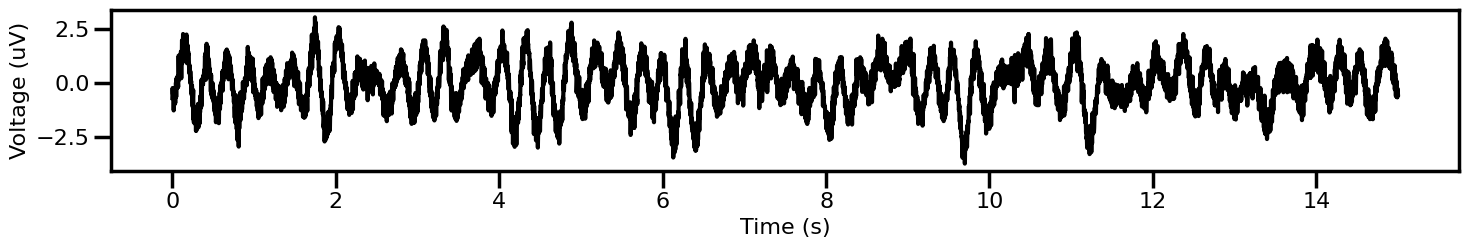

In [85]:
# Simulate timeseries as a combination of aperiodic and periodic components + noise
sim_components = {'sim_knee': {'exponent1' : 0, 'exponent2':-5, 'knee':10},
                   'sim_oscillation': [{'freq' : 4}, {'freq' : 50}]}
fs = 1000
n_seconds = 15
ap_sig = sim_knee(n_seconds, fs,**sim_components['sim_knee'])
sig = sim_peak_oscillation(ap_sig, fs, freq=sim_components['sim_oscillation'][0]['freq'], bw=1, height=3)
sig = sim_peak_oscillation(sig, fs, freq=sim_components['sim_oscillation'][1]['freq'], bw=0.5, height=7)

# Add noise
noise = sim_powerlaw(n_seconds, fs, exponent=0, f_range=(0.1, 200))
sig = sig + 0.3 * noise

times = create_times(n_seconds=n_seconds, fs=fs)
plot_time_series(times, sig)

Compute the power spectrum for the entire signal with the simulated oscillation peaks highlighted

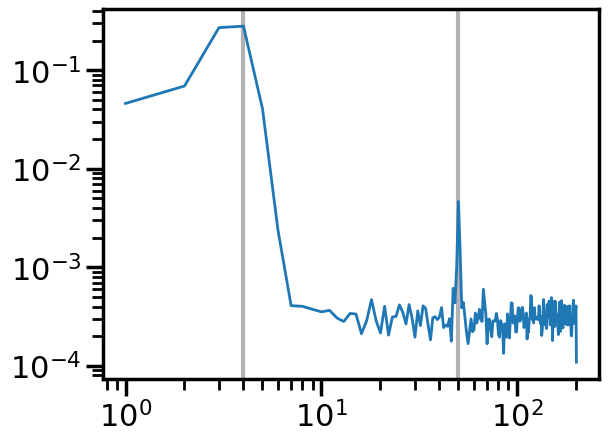

In [ ]:
# Compute the power spectrum using Welch's 
freqs, powers = compute_spectrum(sig, fs=fs, f_range=(0.1,200), avg_type='median', nperseg=fs, noverlap=fs/2)

plt.axvline(sim_components['sim_oscillation'][0]['freq'], color='k', alpha=0.3)
plt.axvline(sim_components['sim_oscillation'][1]['freq'], color='k', alpha=0.3)
plt.loglog(freqs,powers, linewidth=2)

You can fit this power spectrum of the entire signal and it fits fairly well, correctly identifying the oscillatory peaks and with a high r-squared (0.9437), and low error (0.1082). 


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -3.1485,

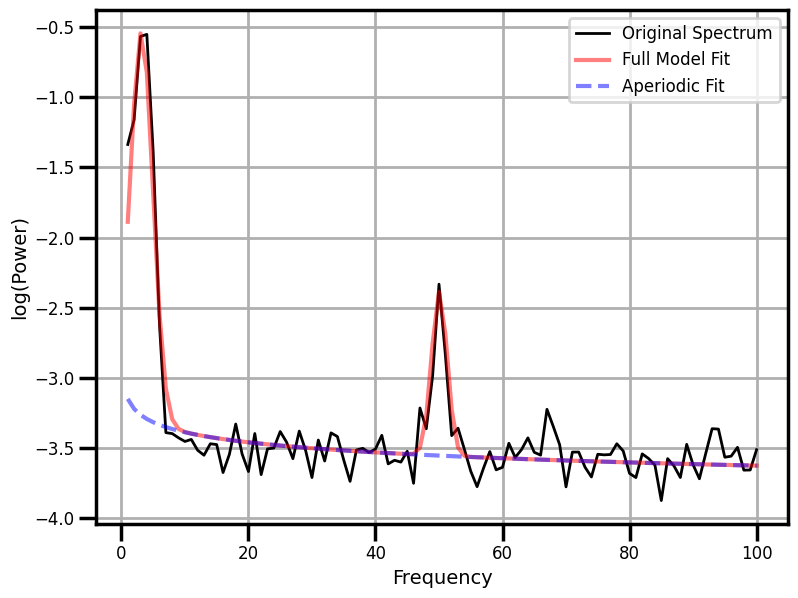

In [109]:
fm = SpectralModel(peak_width_limits=[1, 8], max_n_peaks=3, min_peak_height=0.4)
fm.report(freqs, powers, freq_range=(0,100))

Then, if you were interested in how these spectral parameters changed across the signal, you could do a sliding window approach, computing power spectra in 2-second windows with 50% overlap.

In [86]:
win_len = int(2 * fs)
step = win_len//2  # 50% overlap

all_freqs = []
all_powers = []

for start in range(0, len(sig) - win_len + 1, step):
    seg = sig[start:start + win_len]

    freqs, powers = compute_spectrum(seg, fs=fs, f_range=(0.1, 200), avg_type='median', nperseg=fs, noverlap=fs // 2
    )

    all_freqs.append(freqs)
    all_powers.append(powers)

all_freqs = np.array(all_freqs)     # shape: (n_windows, n_freqs)
all_powers = np.array(all_powers)   # shape: (n_windows, n_freqs)

Example plot of the first four windows show a much noisier PSD

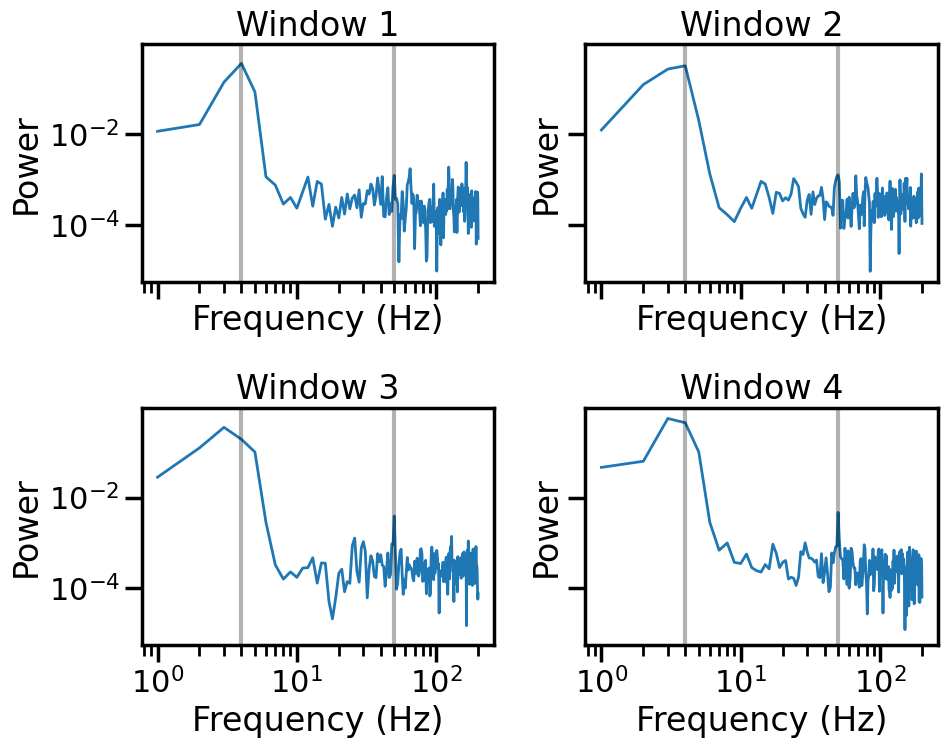

In [111]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for window_i in range(4): # first 4 windows
    ax = axes.flatten()[window_i]
    ax.loglog(all_freqs[window_i], all_powers[window_i], linewidth=2)
    ax.set_title(f'Window {window_i+1}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.axvline(sim_components['sim_oscillation'][0]['freq'], color='k', alpha=0.3)
    ax.axvline(sim_components['sim_oscillation'][1]['freq'], color='k', alpha=0.3)
plt.tight_layout()
plt.show()

When you fit these short-windowed spectra, it is noisier and misidentifies the higher frequency oscillation (50 Hz), and has a lower r-squared (0.7136), and higher error (0.2734). 


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -2.4764,

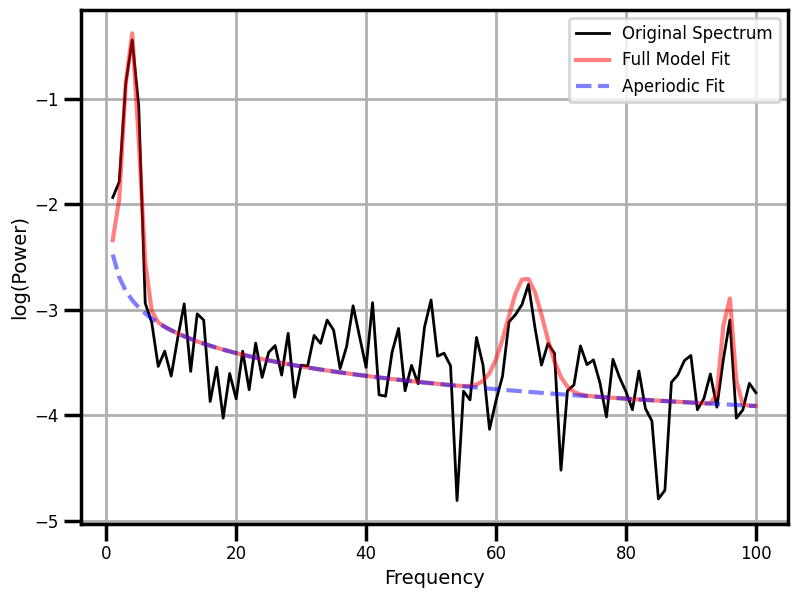

In [110]:
fm = SpectralModel(peak_width_limits=[1, 8], max_n_peaks=3, min_peak_height=0.4)
fm.report(all_freqs[0], all_powers[0], freq_range=(0,100))

### If fits are consistently poor, it can be useful to visualize the frequency-by-frequency error of model fits

We can simulate a power spectrum with a 10 Hz oscillation, *without* a knee, fit it without a knee, and test the error across frequncies

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 3 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.0243, 1.0154                                          
                                                                                                  
                                       1 peaks were found:                                        
          

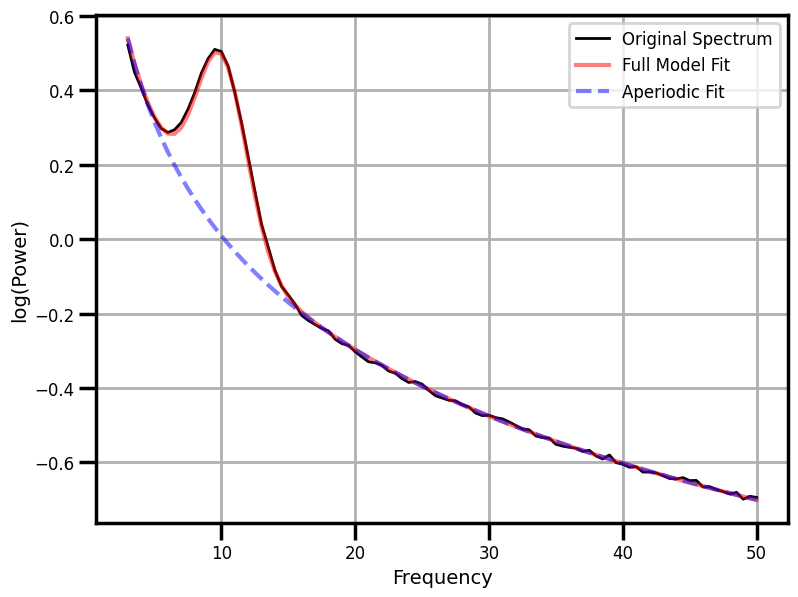

In [134]:
# Simulate an example power spectrum, with no knee, and a 10 Hz oscillatory peak
freqs, powers = sim_power_spectrum(freq_range=[3, 50], aperiodic_params=[1, 1], 
                                   periodic_params=[10, 0.5, 2])

# Initialize a model object
fm = SpectralModel(peak_width_limits=[1,8])

# Parameterize our power spectrum
fm.report(freqs, powers)

When you plot the errors across frequencies, it is largely uniformly distributed, which is a good sign that model fits aren't being driven by a certain frequency.

Average freq-by-freq error:	 0.006


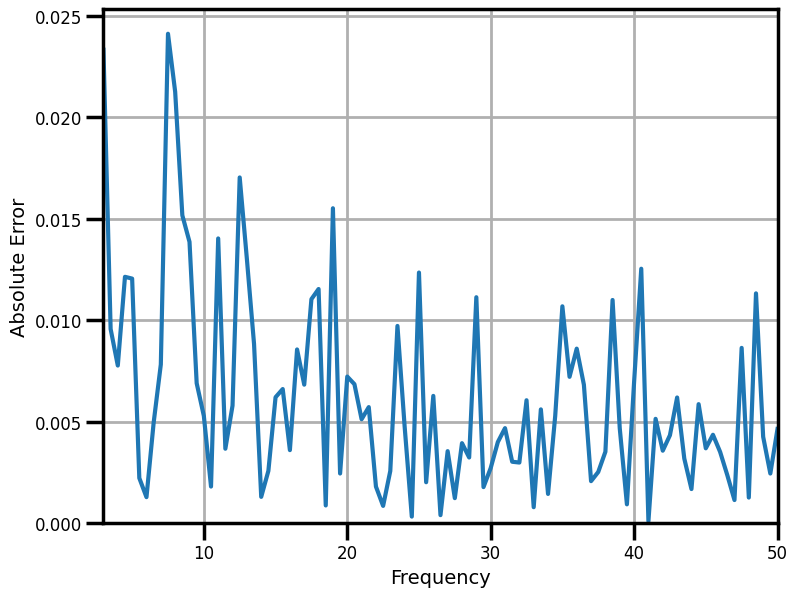

In [ ]:
# Calculate the error per frequency of the model
compute_pointwise_error(fm, plot_errors=True)

# We can also use this function to return the frequency-by-frequency error
errs_fm = compute_pointwise_error(fm, plot_errors=False, return_errors=True)
print('Average freq-by-freq error:\t {:1.3f}'.format(np.mean(errs_fm)))

To see an example of a non-uniformly distributed frequency error plot, we can simualte a power spectrum *with* a knee, and fit it *without* a knee.


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 3 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.2533,

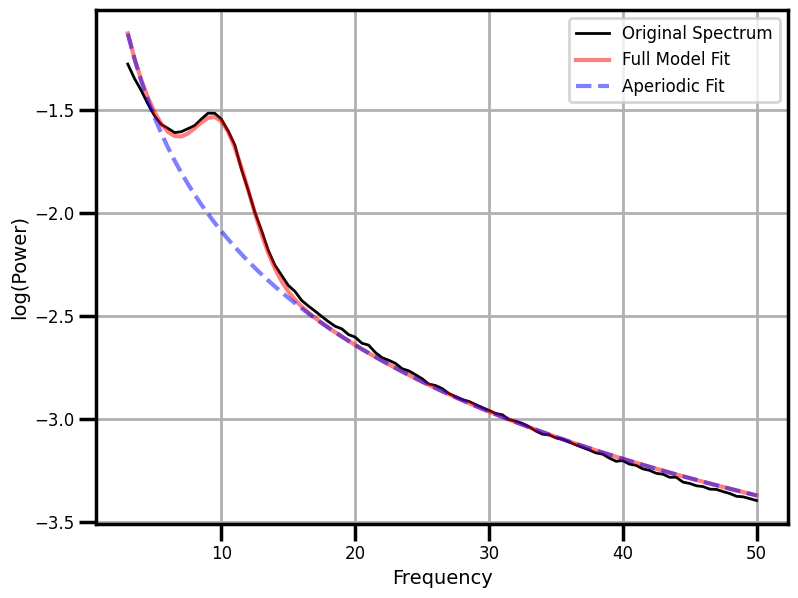

In [142]:
freqs, powers = sim_power_spectrum(freq_range=[3, 50], aperiodic_params=[0, 10, 2], 
                                   periodic_params=[10, 0.5, 2])
fm = SpectralModel()
fm.report(freqs, powers)

When we plot the pointwise frequency error for this fit, we see the error is unusually high for lower frequencies compared to higher ones, indicating some issue with how we fit the data.

Average freq-by-freq error:	 0.019


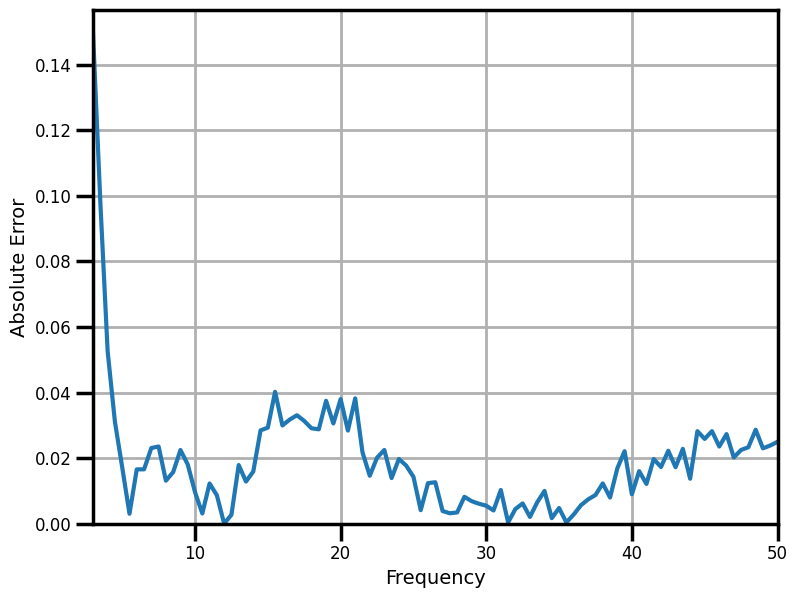

In [143]:
# Calculate the error per frequency of the model
compute_pointwise_error(fm, plot_errors=True)

# We can also use this function to return the frequency-by-frequency error
errs_fm = compute_pointwise_error(fm, plot_errors=False, return_errors=True)
print('Average freq-by-freq error:\t {:1.3f}'.format(np.mean(errs_fm)))

### Conclusion

<>